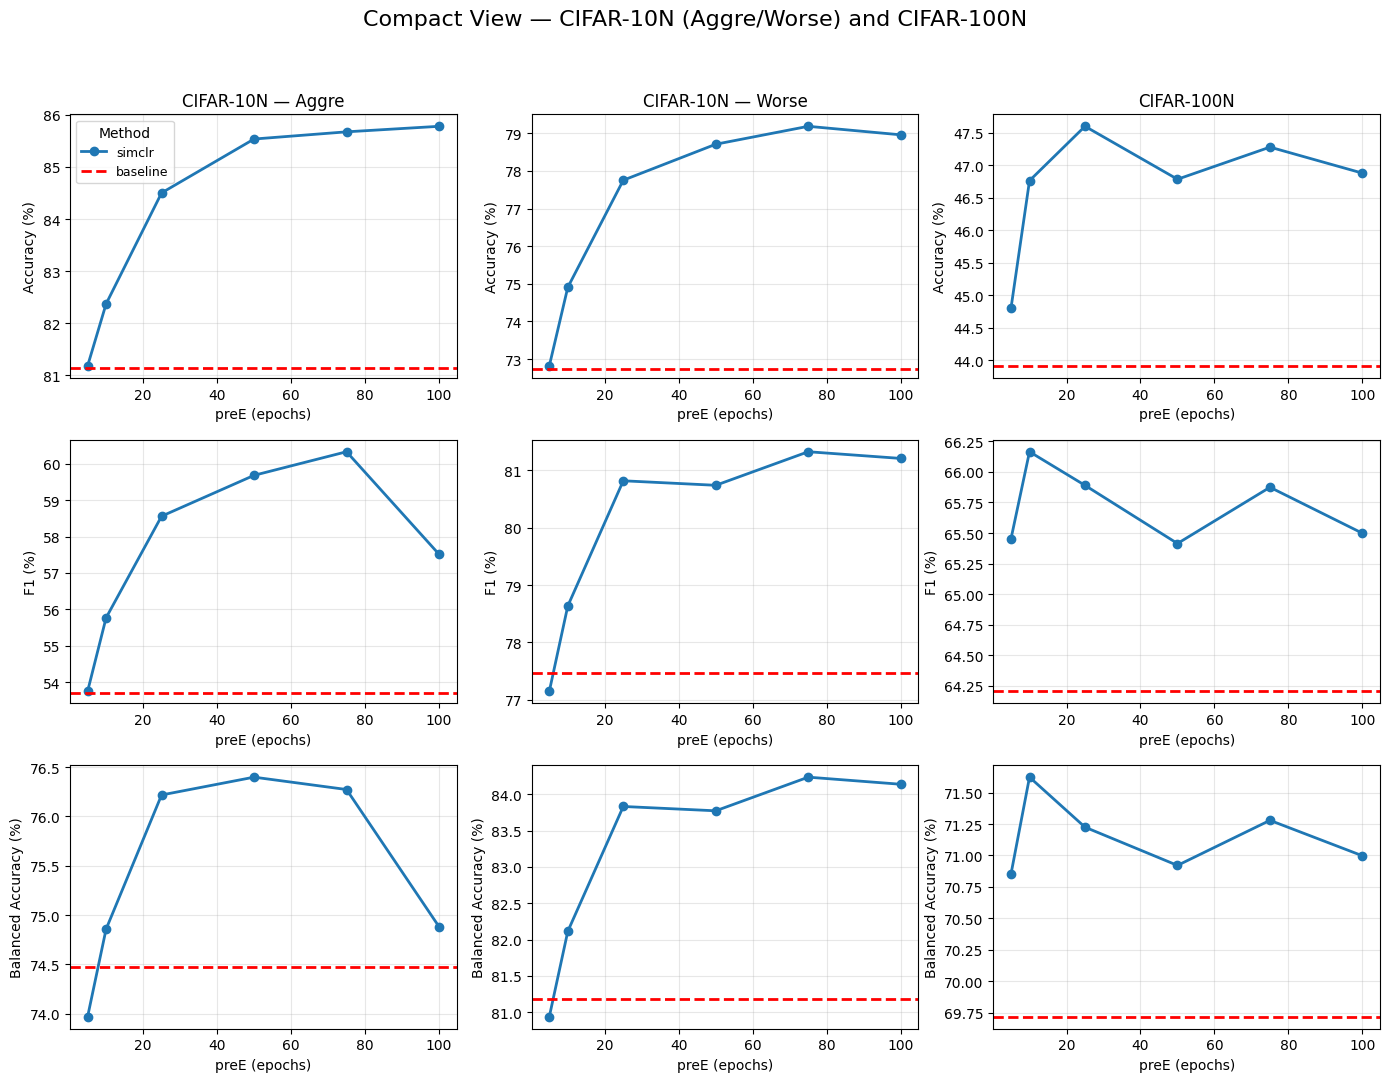

Saved summaries to: results_cifar-n/compact_summaries

=== best_per_method ===
| dataset    | variant   | ssl      |   acc |   acc_preE |    f1 |   f1_preE |   bal_acc |   bal_acc_preE |
|------------|-----------|----------|-------|------------|-------|-----------|-----------|----------------|
| cifar-100n | All       | baseline | 43.91 |          0 | 64.2  |         0 |     69.72 |              0 |
| cifar-100n | All       | simclr   | 47.6  |         25 | 66.17 |        10 |     71.62 |             10 |
| cifar-10n  | Aggre     | baseline | 81.14 |          0 | 53.7  |         0 |     74.48 |              0 |
| cifar-10n  | Aggre     | simclr   | 85.78 |        100 | 60.34 |        75 |     76.4  |             50 |
| cifar-10n  | Worse     | baseline | 72.73 |          0 | 77.46 |         0 |     81.18 |              0 |
| cifar-10n  | Worse     | simclr   | 79.18 |         75 | 81.33 |        75 |     84.24 |             75 |

=== pivot ===
| dataset    | variant   | ssl      |   pr

In [9]:
# =========================
# Compact 3x3 grid + tables
# =========================

# --- imports ---
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tabulate import tabulate

# =========================
# Helpers for parsing names
# =========================
def get_dataset(name: str):
    n = name.lower()
    if "cifar-10n" in n or "cifar10n" in n:
        return "cifar-10n"
    if "cifar-100n" in n or "cifar100n" in n:
        return "cifar-100n"
    return "unknown"

def get_variant(name: str):
    """
    For CIFAR-10N return 'Aggre' or 'Worse'. For CIFAR-100N return 'all'.
    """
    n = name.lower()
    if "cifar-10n" in n or "cifar10n" in n:
        m = re.search(r"cifar[-_]?10n[-_](aggre|worse)", n, re.I)
        return (m.group(1).capitalize() if m else "Unknown")
    if "cifar-100n" in n or "cifar100n" in n:
        return "All"  # no sub-variants for 100N
    return "Unknown"

def get_ssl_method(name: str):
    n = str(name).lower()
    for m in ("simclr", "byol", "simsiam", "barlow"):
        if n.startswith(m):
            return m
    if n.startswith("baseline"):
        return "baseline"
    return "unknown"

def get_pt_epochs(name: str, pretrain_field=None):
    """
    Extract pretraining epochs. Matches preE-<k>, preE_<k>, pre-<k>, pree<k>.
    Baseline -> 0.
    """
    n = name.lower()
    m = re.search(r"pre[e-]?[-_]?(\d+)", n)
    if m:
        return int(m.group(1))
    if get_ssl_method(n) == "baseline":
        return 0
    return int(pretrain_field or 0)

def strip_seed(name: str):
    """Remove trailing seed token like '_s-1' or '-s1'."""
    return re.sub(r"[_-]s[-_]?\d+$", "", name)

# =========================
# CSV metric extraction
# =========================
def _ci_get(df, names):
    if df is None or df.empty: return None
    if isinstance(names, str): names = [names]
    low = {c.lower(): c for c in df.columns}
    for n in names:
        if n in df.columns: return df[n]
        if n.lower() in low: return df[low[n.lower()]]
    return None

def extract_metrics_from_csv(csv_path: Path):
    """
    Returns (acc, f1, bal_acc) as floats (percent if needed).
    Grabs the final non-NaN value from common column name variants.
    """
    if not csv_path.exists():
        return (None, None, None)
    try:
        df = pd.read_csv(csv_path)
    except Exception:
        return (None, None, None)

    # accuracy
    acc_ser = _ci_get(df, ["test_acc","val_acc","accuracy","acc","top1"])
    acc_val = None
    if acc_ser is not None:
        acc_vals = pd.to_numeric(acc_ser, errors="coerce").dropna()
        if len(acc_vals):
            acc_val = float(acc_vals.iloc[-1])
            if acc_val <= 1.5:
                acc_val *= 100.0

    # f1
    f1_ser = _ci_get(df, ["cl_f1","f1","F1"])
    f1_val = None
    if f1_ser is not None:
        f1_vals = pd.to_numeric(f1_ser, errors="coerce").dropna()
        if len(f1_vals):
            f1_val = float(f1_vals.iloc[-1])
            if f1_val <= 1.5:
                f1_val *= 100.0

    # balanced accuracy
    ba_ser = _ci_get(df, ["cl_bal_acc","balanced_accuracy","bal_acc","BA"])
    ba_val = None
    if ba_ser is not None:
        ba_vals = pd.to_numeric(ba_ser, errors="coerce").dropna()
        if len(ba_vals):
            ba_val = float(ba_vals.iloc[-1])
            if ba_val <= 1.5:
                ba_val *= 100.0

    return (acc_val, f1_val, ba_val)

# =========================
# Scanning + aggregation
# =========================
def scan_results(base_dir: Path, recursive: bool = True):
    rows = []

    if recursive:
        exp_dirs = sorted({p.parent for p in base_dir.rglob("metrics.csv")})
    else:
        exp_dirs = []
        for d in sorted(base_dir.glob("*")):
            if d.is_dir() and (d / "metrics.csv").exists():
                exp_dirs.append(d)

    for d in exp_dirs:
        csv = d / "metrics.csv"
        acc, f1, ba = extract_metrics_from_csv(csv)
        if acc is None and f1 is None and ba is None:
            continue

        # Full path for human-readable experiment identifier
        try:
            exp_rel = str(d.relative_to(base_dir))
        except ValueError:
            exp_rel = d.name  # fallback

        # *** IMPORTANT: use only the folder name for parsing ***
        exp_name = d.name

        rows.append({
            "exp": exp_rel,                      # full relative path (for debugging)
            "exp_base": strip_seed(exp_name),    # seed-agnostic id
            "dataset": get_dataset(exp_name),
            "variant": get_variant(exp_name),
            "ssl": get_ssl_method(exp_name),
            "pt_epochs": get_pt_epochs(exp_name, None),
            "acc": acc,
            "f1": f1,
            "bal_acc": ba,
        })

    df = pd.DataFrame(rows)
    if df.empty:
        print(f"No metrics found under: {base_dir}")
        return df

    # numeric + clean
    for c in ["pt_epochs", "acc", "f1", "bal_acc"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # normalize baseline epochs
    df.loc[df["ssl"].str.lower() == "baseline", "pt_epochs"] = 0

    # seed averaging
    gcols = ["exp_base", "dataset", "variant", "ssl", "pt_epochs"]
    metrics = ["acc", "f1", "bal_acc"]
    g = df.groupby(gcols, as_index=False)
    df_mean = g[metrics].mean(numeric_only=True)
    df_cnt  = g.size().rename(columns={"size": "n_seeds"})
    out = df_mean.merge(df_cnt, on=gcols, how="left")
    return out



# =========================
# Plotting
# =========================
def _add_baseline_hline(ax, df_variant, metric_col, label="baseline"):
    base = df_variant[df_variant["ssl"].str.lower()=="baseline"][metric_col].dropna()
    if not base.empty:
        y = base.mean()
        ax.axhline(y, color="red", linestyle="--", linewidth=2, label=label)

def _plot_variant(df_variant: pd.DataFrame, dataset_label: str, variant_label: str):
    """
    For a (dataset, variant) slice, plot:
      - Accuracy (%) vs pretrain epochs (lines per SSL method)
      - F1 (%) vs pretrain epochs
      - Balanced Acc (%) vs pretrain epochs
    Baseline is a red dashed horizontal line.
    """
    if df_variant.empty:
        print(f"[{dataset_label} — {variant_label}] No data to plot.")
        return

    # methods excluding baseline for lines
    methods = [m for m in sorted(df_variant["ssl"].unique()) if m.lower() != "baseline"]

    # make a 3x1 stack
    fig, axes = plt.subplots(3, 1, figsize=(7, 12))
    fig.suptitle(f"{dataset_label} — {variant_label}", fontsize=14)

    def _plot(ax, metric_col, ylabel):
        # lines: one per SSL method (excluding baseline)
        for method in methods:
            gm = df_variant[df_variant["ssl"]==method].sort_values("pt_epochs")
            if gm.empty or gm[metric_col].isna().all():
                continue
            ax.plot(gm["pt_epochs"], gm[metric_col], marker="o", linewidth=2, label=method)

        # baseline: dashed red horizontal line
        _add_baseline_hline(ax, df_variant, metric_col, label="baseline")

        ax.set_xlabel("Pretrain epochs (preE)")
        ax.set_ylabel(ylabel)
        ax.grid(True, alpha=0.3)
        ax.legend(title="Method", fontsize=9)

    # Accuracy
    if df_variant["acc"].notna().any():
        _plot(axes[0], "acc", "Accuracy (%)")
    else:
        axes[0].set_visible(False)

    # F1
    if df_variant["f1"].notna().any():
        # label with (%) if values look like percents
        ylab = "F1 (%)" if (df_variant["f1"].max() and df_variant["f1"].max()>1.5) else "F1"
        _plot(axes[1], "f1", ylab)
    else:
        axes[1].set_visible(False)

    # Balanced Accuracy
    if df_variant["bal_acc"].notna().any():
        ylab = "Balanced Accuracy (%)" if (df_variant["bal_acc"].max() and df_variant["bal_acc"].max()>1.5) else "Balanced Accuracy"
        _plot(axes[2], "bal_acc", ylab)
    else:
        axes[2].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_all(base_dirs, recursive: bool = True):
    # allow a single Path or a list
    if isinstance(base_dirs, (str, Path)):
        base_dirs = [base_dirs]

    dfs = []
    for d in base_dirs:
        df_d = scan_results(Path(d), recursive=recursive)
        if not df_d.empty:
            dfs.append(df_d)

    if not dfs:
        print("No metrics found in any provided directory.")
        return pd.DataFrame()

    df = pd.concat(dfs, ignore_index=True)

    if df.empty:
        return df

    # ===== CIFAR-10N: plot Aggre & Worse separately
    df10 = df[df["dataset"] == "cifar-10n"]
    for variant in ["Aggre", "Worse"]:
        slice10 = df10[df10["variant"] == variant]
        if not slice10.empty:
            _plot_variant(slice10, "CIFAR-10N", variant)

    # ===== CIFAR-100N: single set (no Aggre/Worse)
    df100 = df[df["dataset"] == "cifar-100n"].copy()
    if not df100.empty:
        df100["variant"] = "All"
        _plot_variant(df100, "CIFAR-100N", "All")

    return df





def _compact_panel(ax, df_slice, metric_col, ylabel):
    """Draw one panel: metric vs preE for methods (baseline = dashed red)."""
    if df_slice.empty or df_slice[metric_col].isna().all():
        ax.set_axis_off()
        return

    methods = [m for m in sorted(df_slice["ssl"].unique()) if m.lower() != "baseline"]
    for method in methods:
        gm = df_slice[df_slice["ssl"]==method].sort_values("pt_epochs")
        if gm.empty or gm[metric_col].isna().all():
            continue
        ax.plot(gm["pt_epochs"], gm[metric_col], marker="o", linewidth=2, label=method)

    # baseline as dashed red horizontal line
    _add_baseline_hline(ax, df_slice, metric_col, label="baseline")

    ax.set_xlabel("preE (epochs)")
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    # keep legend only in top row to save space; caller can manage

def _canonical_slices(df):
    """
    Return list of (title, dataframe) slices in canonical order:
    [CIFAR-10N Aggre, CIFAR-10N Worse, CIFAR-100N]
    """
    slices = []
    # CIFAR-10N Aggre
    s1 = df[(df["dataset"]=="cifar-10n") & (df["variant"].str.lower()=="aggre")]
    if not s1.empty:
        slices.append(("CIFAR-10N — Aggre", s1))
    else:
        slices.append(("CIFAR-10N — Aggre", pd.DataFrame()))

    # CIFAR-10N Worse
    s2 = df[(df["dataset"]=="cifar-10n") & (df["variant"].str.lower()=="worse")]
    if not s2.empty:
        slices.append(("CIFAR-10N — Worse", s2))
    else:
        slices.append(("CIFAR-10N — Worse", pd.DataFrame()))

    # CIFAR-100N (no sub-variants)
    s3 = df[df["dataset"]=="cifar-100n"].copy()
    if not s3.empty:
        s3["variant"] = "All"
    slices.append(("CIFAR-100N", s3))
    return slices

def _make_summary_tables(df):
    """
    Build compact summary tables:
      1) mean over seeds (already) and then best per (dataset, variant, ssl) by metric
      2) a pivot table for quick scanning across preE
    Returns dict of DataFrames.
    """
    out = {}

    # Best per (dataset, variant, ssl) for each metric
    best_rows = []
    for (ds, var, ssl), g in df.groupby(["dataset","variant","ssl"]):
        # ignore baseline's preE dimension for "best" (it's 0)
        row = {"dataset": ds, "variant": var, "ssl": ssl}
        for m in ["acc","f1","bal_acc"]:
            if m in g and g[m].notna().any():
                idx = g[m].idxmax()
                row[m] = g.loc[idx, m]
                row[m+"_preE"] = int(g.loc[idx, "pt_epochs"])
        best_rows.append(row)
    out["best_per_method"] = pd.DataFrame(best_rows).sort_values(["dataset","variant","ssl"])

    pivot = df.sort_values(["dataset","variant","ssl","pt_epochs"])[
        ["dataset","variant","ssl","pt_epochs","acc","f1","bal_acc","n_seeds"]
    ].rename(columns={"pt_epochs":"preE"})

    # keep only preE = 0, 25, or 50
    pivot = pivot[pivot["preE"].isin([0, 25, 50])]

    out["pivot"] = pivot
    
    for k in out:
        out[k] = out[k].round(2)
    return out

def plot_compact_grid(base_dir: Path, save_summary: bool=False, summary_dir: Path=None, recursive: bool = True):
    """
    3x3 grid (Acc/F1/BalAcc × Aggre/Worse/100N) + summary tables.
    """
    df = scan_results(base_dir, recursive=recursive)
    if df.empty:
        print(f"No data under {base_dir}")
        return df, {}

    slices = _canonical_slices(df)

    # --- Figure layout: 3 rows (metrics) x 3 cols (slices)
    fig, axes = plt.subplots(3, 3, figsize=(14, 11))
    fig.suptitle("Compact View — CIFAR-10N (Aggre/Worse) and CIFAR-100N", fontsize=16)

    metric_specs = [
        ("acc", "Accuracy (%)"),
        ("f1",  "F1 (%)" if (df["f1"].max(skipna=True) or 0) > 1.5 else "F1"),
        ("bal_acc", "Balanced Accuracy (%)" if (df["bal_acc"].max(skipna=True) or 0) > 1.5 else "Balanced Accuracy")
    ]

    # draw
    for col, (title, df_slice) in enumerate(slices):
        for row, (metric, ylabel) in enumerate(metric_specs):
            ax = axes[row, col]
            _compact_panel(ax, df_slice, metric, ylabel)
            if row == 0:
                ax.set_title(title, fontsize=12)
            # legends only on top-left panel for compactness
            if row == 0 and col == 0:
                handles, labels = ax.get_legend_handles_labels()
                if handles:
                    ax.legend(title="Method", fontsize=9)
            else:
                ax.legend().set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- Summary tables
    tables = _make_summary_tables(df)
    
    # Optionally save
    if save_summary:
        out_dir = summary_dir if summary_dir is not None else (base_dir / "compact_summaries")
        out_dir.mkdir(parents=True, exist_ok=True)
        for name, tdf in tables.items():
            tdf.to_csv(out_dir / f"{name}.csv", index=False)
        print(f"Saved summaries to: {out_dir}")

    
    # --- Pretty print tables with tabulate
    for name, tdf in tables.items():
        print(f"\n=== {name} ===")
        print(tabulate(tdf.head(15), headers='keys', tablefmt='github', showindex=False))
        if len(tdf) > 15:
            print(f"... ({len(tdf)} rows total)")



    # --- Compact 3-row summary: (dataset slice) × [Acc/F1/BA × (baseline, simclr)]
    best = tables["best_per_method"].copy()
    
    # Build a slice label that matches your request
    best["slice"] = np.where(
        best["dataset"].str.lower().eq("cifar-100n"),
        "cifar-100n",
        best["dataset"] + "-" + best["variant"]
    )
    
    # Keep only the three slices and the two methods we care about
    wanted_slices = ["cifar-10n-Aggre", "cifar-10n-Worse", "cifar-100n"]
    best = best[
        best["slice"].isin(wanted_slices) &
        best["ssl"].str.lower().isin(["baseline","simclr"])
    ]
    
    # Pick metrics and round
    small = best[["slice","ssl","acc","f1","bal_acc"]].round(2)
    
    # Pivot so columns are metric × method
    wide = small.pivot(index="slice", columns="ssl", values=["acc","f1","bal_acc"])
    
    # Order rows and columns, and give friendly column names
    row_order = ["cifar-10n-Aggre", "cifar-10n-Worse", "cifar-100n"]
    wide = wide.reindex(row_order)
    
    # Flatten MultiIndex columns
    wide.columns = [
        ("Acc_" if a=="acc" else "F1_" if a=="f1" else "BA_") + b
        for a, b in wide.columns
    ]
    
    # Column order: baseline first, then simclr
    col_order = ["Acc_baseline","Acc_simclr","F1_baseline","F1_simclr","BA_baseline","BA_simclr"]
    wide = wide.reindex(columns=col_order)
    
    # Final tidy table
    compact_table = wide.reset_index().rename(columns={"slice":"dataset"}).fillna("—")
    
    # Pretty-print with tabulate
    print("\n=== compact_summary (best per dataset × method) ===")
    print(tabulate(compact_table, headers="keys", tablefmt="github", showindex=False))

    
    
    


    
        
    return df, tables

# =========================
# Example call
# =========================

BASE_DIR = Path("results_cifar-n")#/results_cifar-100n")
df_all, summary = plot_compact_grid(BASE_DIR, save_summary=True, recursive=True)


In [4]:
import numpy as np
import pandas as pd

def make_cifarn_latex_table_fixed_preE(summary_dict, preE_map):
    """
    Build a CIFAR-N LaTeX table using *explicitly chosen* preE values
    for SimCLR, per dataset slice.

    preE_map: dict mapping
        "cifar-10n-Aggre" -> int preE for SimCLR
        "cifar-10n-Worse" -> int preE for SimCLR
        "cifar-100n"      -> int preE for SimCLR
    Baseline is always taken at preE = 0.
    """
    pivot = summary_dict["pivot"].copy()  # columns: dataset, variant, ssl, preE, acc, f1, bal_acc, n_seeds

    # canonical slices
    slices = ["cifar-10n-Aggre", "cifar-10n-Worse", "cifar-100n"]

    # pretty labels for the LaTeX table
    label_map = {
        "cifar-10n-Aggre": r"CIFAR-10N (Aggre)",
        "cifar-10n-Worse": r"CIFAR-10N (Worse)",
        "cifar-100n":      r"CIFAR-100N",
    }

    # helper: map slice -> (dataset, variant)
    def parse_slice(s):
        if s == "cifar-100n":
            return "cifar-100n", "All"
        ds, var = s.split("-", 1)  # e.g. cifar-10n-Aggre
        return ds, var

    # collect rows (one per slice × method)
    rows = []

    for s in slices:
        ds, var = parse_slice(s)
        sim_preE = preE_map.get(s, None)

        # baseline: preE = 0
        base_row = pivot[
            (pivot["dataset"] == ds) &
            (pivot["variant"] == var) &
            (pivot["ssl"].str.lower() == "baseline") &
            (pivot["preE"] == 0)
        ]

        # simclr: user-chosen preE
        if sim_preE is not None:
            sim_row = pivot[
                (pivot["dataset"] == ds) &
                (pivot["variant"] == var) &
                (pivot["ssl"].str.lower() == "simclr") &
                (pivot["preE"] == sim_preE)
            ]
        else:
            sim_row = pd.DataFrame()

        # we’ll allow missing rows, but mark them as NaN
        if base_row.empty:
            acc_b = f1_b = ba_b = np.nan
        else:
            r = base_row.iloc[0]
            acc_b, f1_b, ba_b = r["acc"], r["f1"], r["bal_acc"]

        if sim_row.empty:
            acc_s = f1_s = ba_s = np.nan
        else:
            r = sim_row.iloc[0]
            acc_s, f1_s, ba_s = r["acc"], r["f1"], r["bal_acc"]

        rows.append({
            "slice": s,
            "dataset_label": label_map.get(s, s),
            "Acc_baseline": acc_b,
            "Acc_simclr":   acc_s,
            "F1_baseline":  f1_b,
            "F1_simclr":    f1_s,
            "BA_baseline":  ba_b,
            "BA_simclr":    ba_s,
        })

    df = pd.DataFrame(rows).set_index("slice").round(2)

    def fmt_pair(baseline, sim):
        """Format 'Base & SimCLR' with bold on the better one."""
        def _fmt(x):
            return "—" if pd.isna(x) else f"{x:.2f}"

        b = _fmt(baseline)
        s = _fmt(sim)

        if (not pd.isna(baseline)) and (not pd.isna(sim)):
            if sim > baseline:
                s = r"\textbf{" + s + "}"
            elif baseline > sim:
                b = r"\textbf{" + b + "}"

        return f"{b} & {s}"

    # ---------- Build LaTeX ----------
    lines = []
    lines.append(r"\begin{table}[H]")
    lines.append(r"\centering")
    lines.append(r"\caption{Performance comparison on real-world noisy datasets CIFAR-10N and CIFAR-100N."
                 r" Accuracy, F1-score, and Balanced Accuracy are shown for baseline and SimCLR-pretrained models.}")
    lines.append(r"\label{tab:CIFAR-N}")
    lines.append(r"\resizebox{\columnwidth}{!}{")
    lines.append(r"\begin{tabular}{@{}lcccccc@{}}")
    lines.append(r"\toprule")
    lines.append(r"\multirow{2}{*}{Dataset} & \multicolumn{2}{c}{Accuracy} & \multicolumn{2}{c}{F1} & \multicolumn{2}{c}{BA} \\")
    lines.append(r"\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(l){6-7}")
    lines.append(r" & Base & SimCLR & Base & SimCLR & Base & SimCLR \\")
    lines.append(r"\midrule")

    for s in slices:
        if s not in df.index:
            continue
        r = df.loc[s]
        ds_label = r["dataset_label"]

        acc_pair = fmt_pair(r["Acc_baseline"], r["Acc_simclr"])
        f1_pair  = fmt_pair(r["F1_baseline"],  r["F1_simclr"])
        ba_pair  = fmt_pair(r["BA_baseline"],  r["BA_simclr"])

        lines.append(f"{ds_label} & {acc_pair} & {f1_pair} & {ba_pair} \\\\")

    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")
    lines.append(r"}")
    lines.append(r"\end{table}")
    lines.append("")

    # Also log which preE was used (LaTeX comments)
    lines.append(r"% --- SimCLR preE values used in this table ---")
    for s in slices:
        pe = preE_map.get(s, None)
        if pe is not None:
            lines.append(f"%   {label_map.get(s, s)}: preE = {pe}")
        else:
            lines.append(f"%   {label_map.get(s, s)}: preE = (not specified)")

    latex_str = "\n".join(lines)
    print(latex_str)
    return latex_str


In [6]:
preE_choice = {
    "cifar-10n-Aggre": 50,   # use SimCLR preE=50 for this slice
    "cifar-10n-Worse": 50,
    "cifar-100n":      25,  # maybe you trained longer here
}

latex_table = make_cifarn_latex_table_fixed_preE(summary, preE_choice)


\begin{table}[H]
\centering
\caption{Performance comparison on real-world noisy datasets CIFAR-10N and CIFAR-100N. Accuracy, F1-score, and Balanced Accuracy are shown for baseline and SimCLR-pretrained models.}
\label{tab:CIFAR-N}
\resizebox{\columnwidth}{!}{
\begin{tabular}{@{}lcccccc@{}}
\toprule
\multirow{2}{*}{Dataset} & \multicolumn{2}{c}{Accuracy} & \multicolumn{2}{c}{F1} & \multicolumn{2}{c}{BA} \\
\cmidrule(lr){2-3} \cmidrule(lr){4-5} \cmidrule(l){6-7}
 & Base & SimCLR & Base & SimCLR & Base & SimCLR \\
\midrule
CIFAR-10N (Aggre) & — & — & — & — & — & — \\
CIFAR-10N (Worse) & — & — & — & — & — & — \\
CIFAR-100N & 43.91 & \textbf{47.60} & 64.20 & \textbf{65.89} & 69.72 & \textbf{71.23} \\
\bottomrule
\end{tabular}
}
\end{table}

% --- SimCLR preE values used in this table ---
%   CIFAR-10N (Aggre): preE = 50
%   CIFAR-10N (Worse): preE = 50
%   CIFAR-100N: preE = 25
